<a href="https://colab.research.google.com/github/Ng-ethe/2021-image-classification/blob/main/Copy_TB_classification2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# TASKS

# implement RoI
# try lossless compression
# compare the previous 2

Tuberculosis (TB) is the ninth leading cause of death worldwide. In 2016, an estimated 417,000 people died from Tuberculosis in Africa, and 1.7 million globally. In South Africa Tuberculosis is the leading cause of death with 450,000 people developing the disease every year and 89,000 people dying from it. That’s ten people every hour.

With over 800,000 confirmed cases and 18,000 deaths recorded in Africa and over 17 million confirmed cases and 670,000 recorded deaths globally as of August 2, 2020, the COVID-19 global pandemic continues to take a heavy toll around the world. In countries with a high prevalence level of TB, TB can create additional complexity to the COVID-19 response. And by the same token, COVID-19 is adding new complexity to the ongoing battle against TB.

For both TB and COVID-19 patients, medical imaging (Chest X-Rays and/or CT Scans) can sometimes be performed to identify and manage any chest abnormalities that may develop.

This challenge asks you to build an AI model that can classify Tuberculosis and Normal X-Ray results. With Tuberculosis infections still active as the COVID-19 pandemic continues, an automated tool to help identify TB has the potential to reduce hospital workload and optimize patient care during a time when hospitals are being overwhelmed by COVID-19 cases.

https://zindi.africa/competitions/runmila-ai-institute-minohealth-ai-labs-tuberculosis-classification-via-x-rays-challenge/data


The data have been split into a test and training set. The training set, on which you will train your models, contains 353 images of x-rays of TB-positive lungs and 365 images of x-rays of healthy lungs. The test set contains 82 images.

You are asked to build a machine learning model to predict the likelihood that the lung in the x-ray is TB-positive. In your submission file, LABEL=1 means the x-ray is TB-positive. Please keep your values as probabilities.

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
%matplotlib inline



In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
TrainList = pd.read_csv("/content/drive/MyDrive/TB_classification_project/TrainList.csv", ",")
TrainList.head()
TrainList.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  718 non-null    object
 1   ID        718 non-null    object
 2   LABEL     718 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 17.0+ KB


In [5]:
# filter out list of files which are TB positive i.e. label = 1
tb_pve_id = TrainList[TrainList.LABEL == 1]


# filter out list of files which are TB negative i.e. label = 0
tb_nve_id = TrainList[TrainList.LABEL == 0]


In [6]:
train = os.path.join('/content/drive/My Drive/TB_classification_project/train') # image folder
train

'/content/drive/My Drive/TB_classification_project/train'

In [7]:
TrainList["filename"].count()

718

In [8]:
#print ( len([name for name in os.listdir('/content/drive/My Drive/TB_classification_project/train/TB/') if os.path.isfile(name)]))

In [9]:
import os
count1 = 0
d = "/content/drive/My Drive/TB_classification_project/train/TB/"
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        count1 += 1
print (count1)

353


In [10]:
import os
count2 = 0
d = "/content/drive/My Drive/TB_classification_project/train/normal/"
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        count2 += 1
print (count2)

365


In [11]:
print (count1 +count2)

718


In [14]:
import cv2

img = "/content/drive/My Drive/TB_classification_project/train/TB/VTYNBFTO.png"
edges = cv2.Canny(img,threshold1=150,threshold2=200)
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

TypeError: ignored

In [ ]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow


src = cv.imread(r"/content/drive/My Drive/TB_classification_project/train/TB/VTYNBFTO.png") # Read picture
ROI = np.zeros(src.shape, np.uint8)  # Create an empty numpy array of the same size as the original image for storageROIInformation

gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)  # Grayscale 
ret, binary = cv.threshold(gray,
			   150, 255, 
			   cv.THRESH_BINARY_INV | cv.THRESH_TRIANGLE)  # Adaptive Binarization
			   
contours, hierarchy= cv.findContours(binary, 
			   cv.RETR_EXTERNAL,
               cv.CHAIN_APPROX_SIMPLE)  #out_binary,  # Find all contours, each contour information is stored in the contours array


for cnt in range(len(contours)):  # Process each contour based on the number of contours
         # Contour approximation, the specific principles need to be studied in depth
    epsilon = 0.01 * cv.arcLength(contours[cnt], True)
    approx = cv.approxPolyDP(contours[cnt], epsilon, True)  # Save the vertex information of the approximation result
    							        # The number of vertices determines the contour shape 
         # Calculate the contour center position							   
    mm = cv.moments(contours[cnt])
    if mm['m00'] != 0:
        cx = int(mm['m10'] / mm['m00'])
        cy = int(mm['m01'] / mm['m00'])
        color = src[cy][cx]
        color_str = "(" + str(color[0]) + ", " + str(color[1]) + ", " + str(color[2]) + ")"
        p = cv.arcLength(contours[cnt], True)
        area = cv.contourArea(contours[cnt])
        
                 # Analyze geometry
        corners = len(approx)
        if corners == 3 and (color[2]>=150 or color[0]>=150) and area<1000:    # A series of judgment conditions are adjusted by the characteristics of the project
            cv.drawContours(ROI, contours, cnt, (255, 255, 255), -1)    # AtROIDraw an outline on the empty canvas and fill it with white (the last parameter is the width of the outline line, if it is a negative number, it will directly fill the area)
            imgroi = ROI & src  # ROIAND the original image to filter out the original imageROIarea
            cv.imshow("ROI", imgroi)
            #cv.imwrite(r"D:\ROI.jpg")
            
        if corners >= 10 and (color[2]>=150 or color[0]>=150) and area>1000:
            cv.drawContours(ROI, contours, cnt, (255, 255, 255), -1)
            imgroi = ROI & src
            cv2_imshow( imgroi) #"ROI",
            #cv.imshow("ROI", imgroi） 
            #cv.imwrite(r"D:\ROI.jpg")

            
cv.waitKey(0)
cv.destroyAllWindows()         



## Histogram Equalization
https://medium.com/analytics-vidhya/image-equalization-contrast-enhancing-in-python-82600d3b371c
https://iq.opengenus.org/contrast-enhancement-algorithms/

True

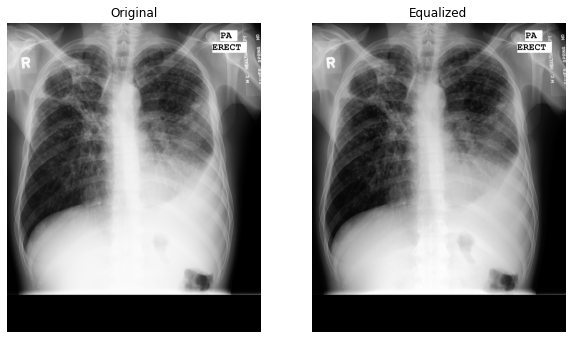

In [16]:
# Histogram equalization
import numpy as np
import cv2
import json
from matplotlib import pyplot as plt

def read_this(image_file, gray_scale=False):
    image_src = cv2.imread(image_file)
    if gray_scale:
        image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2GRAY)
    else:
        image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
    return image_src


def equalize_this(image_file, with_plot=False, gray_scale=False):
    image_src = read_this(image_file=image_file, gray_scale=gray_scale)
    if not gray_scale:
        r_image, g_image, b_image = cv2.split(image_src)

        r_image_eq = cv2.equalizeHist(r_image)
        g_image_eq = cv2.equalizeHist(g_image)
        b_image_eq = cv2.equalizeHist(b_image)

        image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
        cmap_val = None
    else:
        image_eq = cv2.equalizeHist(image_src)
        cmap_val = 'gray'

    if with_plot:
        fig = plt.figure(figsize=(10, 20))

        ax1 = fig.add_subplot(2, 2, 1)
        ax1.axis("off")
        ax1.title.set_text('Original')
        ax2 = fig.add_subplot(2, 2, 2)
        ax2.axis("off")
        ax2.title.set_text("Equalized")

        ax1.imshow(image_src, cmap=cmap_val)
        ax2.imshow(image_eq, cmap=cmap_val)
        return True
    return image_eq

equalize_this(image_file="/content/drive/My Drive/TB_classification_project/train/TB/VTYNBFTO.png", with_plot=True)

True

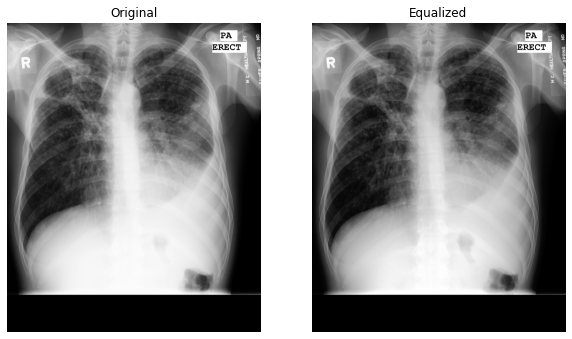

In [17]:
equalize_this(image_file="/content/drive/My Drive/TB_classification_project/train/TB/VTYNBFTO.png", with_plot=True, gray_scale=True)

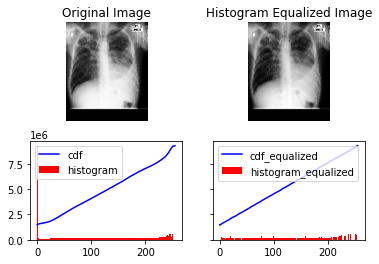

In [18]:

# Reading the original image, here 1 implies that image is read as color
image_c = cv2.imread("/content/drive/My Drive/TB_classification_project/train/TB/VTYNBFTO.png", 1)

# Generating the histogram of the original image
hist_c,bins_c = np.histogram(image_c.flatten(),256,[0,256])

# Generating the cumulative distribution function of the original image
cdf_c = hist_c.cumsum()
cdf_c_normalized = cdf_c * hist_c.max()/ cdf_c.max()


# Converting the image to YCrCb
image_yuv = cv2.cvtColor(image_c, cv2.COLOR_BGR2YUV)

# Applying Histogram Equalization on the original imageof the Y channel
image_yuv[:,:,0] = cv2.equalizeHist(image_yuv[:,:,0])

# Convert the YUV image back to RGB format
image_c_equalized = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2BGR)

# Generating the histogram of the equalized image
hist_c_equalized, bins_c_equalized = np.histogram(image_c_equalized.flatten(),256,[0,256])

# Generating the cumulative distribution function of the original image
cdf_c_equalized = hist_c_equalized.cumsum()
cdf_c_equalized_normalized = cdf_c_equalized * hist_c_equalized.max()/ cdf_c_equalized.max()


#Plotting the Original and Histogram Equalized Image, Histogram and CDF
fig, axs = plt.subplots(2, 2)

axs[0, 0].imshow(cv2.cvtColor(image_c, cv2.COLOR_BGR2RGB))
axs[0, 0].axis('off')
axs[0, 0].set_title('Original Image')

axs[0, 1].imshow(cv2.cvtColor(image_c_equalized, cv2.COLOR_BGR2RGB))
axs[0, 1].axis('off')
axs[0, 1].set_title('Histogram Equalized Image')


axs[1, 0].plot(cdf_c_normalized, color = 'b')
axs[1, 0].hist(image_c.flatten(),256,[0,256], color = 'r')
axs[1, 0].legend(('cdf','histogram'), loc = 'upper left')



axs[1, 1].plot(cdf_c_equalized_normalized, color = 'b')
axs[1, 1].hist(image_c_equalized.flatten(),256,[0,256], color = 'r')
axs[1, 1].legend(('cdf_equalized','histogram_equalized'), loc = 'upper left')


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

Applying CLAHE instead of equalize_hist():



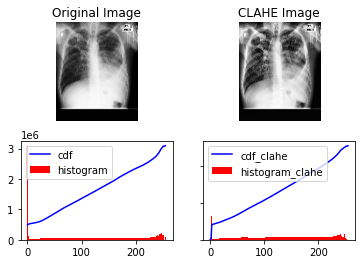

In [19]:
#Reading the original image, here 0 implies that image is read as grayscale
image = cv2.imread("/content/drive/My Drive/TB_classification_project/train/TB/VTYNBFTO.png", 0)

#Generating the histogram of the original image
hist,bins = np.histogram(image.flatten(),256,[0,256])

#Generating the cumulative distribution function of the original image
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

#Creating CLAHE 
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))

#Apply CLAHE to the original image
image_clahe = clahe.apply(image)

#Generating the histogram of the image after applying CLAHE
hist_clahe,bins_clahe = np.histogram(image_clahe.flatten(),256,[0,256])

#Generating the cumulative distribution function of the original image
cdf_clahe = hist_clahe.cumsum()
cdf_clahe_normalized = cdf_clahe * hist_clahe.max()/ cdf_clahe.max()

#Plotting the Original and Histogram Equalized Image, Histogram and CDF
fig, axs = plt.subplots(2, 2)

axs[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0, 0].axis('off')
axs[0, 0].set_title('Original Image')

axs[0, 1].imshow(cv2.cvtColor(image_clahe, cv2.COLOR_BGR2RGB))
axs[0, 1].axis('off')
axs[0, 1].set_title('CLAHE Image')


axs[1, 0].plot(cdf_normalized, color = 'b')
axs[1, 0].hist(image.flatten(),256,[0,256], color = 'r')
axs[1, 0].legend(('cdf','histogram'), loc = 'upper left')



axs[1, 1].plot(cdf_clahe_normalized, color = 'b')
axs[1, 1].hist(image_clahe.flatten(),256,[0,256], color = 'r')
axs[1, 1].legend(('cdf_clahe','histogram_clahe'), loc = 'upper left')


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

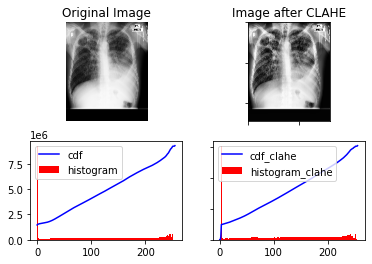

In [20]:

#Converting the image to YCrCb
image_yuv = cv2.cvtColor(image_c, cv2.COLOR_BGR2YUV)

#Creating CLAHE 
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))

# Applying Histogram Equalization on the original imageof the Y channel
image_yuv[:,:,0] = clahe.apply(image_yuv[:,:,0])

# convert the YUV image back to RGB format
image_c_clahe = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2BGR)

#Generating the histogram of the image after applying CLAHE
hist_c_clahe, bins_c_clahe = np.histogram(image_c_clahe.flatten(),256,[0,256])

#Generating the cumulative distribution function of the original image
cdf_c_clahe = hist_c_clahe.cumsum()
cdf_c_clahe_normalized = cdf_c_clahe * hist_c_clahe.max()/ cdf_c_clahe.max()

#Plotting the Original and Histogram Equalized Image, Histogram and CDF
fig, axs = plt.subplots(2, 2)

axs[0, 0].imshow(cv2.cvtColor(image_c, cv2.COLOR_BGR2RGB))
axs[0, 0].axis('off')
axs[0, 0].set_title('Original Image')

axs[0, 1].imshow(cv2.cvtColor(image_c_clahe, cv2.COLOR_BGR2RGB))
axs[0, 0].axis('off')
axs[0, 1].set_title('Image after CLAHE')


axs[1, 0].plot(cdf_c_normalized, color = 'b')
axs[1, 0].hist(image_c.flatten(),256,[0,256], color = 'r')
axs[1, 0].legend(('cdf','histogram'), loc = 'upper left')



axs[1, 1].plot(cdf_c_clahe_normalized, color = 'b')
axs[1, 1].hist(image_c_clahe.flatten(),256,[0,256], color = 'r')
axs[1, 1].legend(('cdf_clahe','histogram_clahe'), loc = 'upper left')


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [21]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv.imread("/content/drive/My Drive/TB_classification_project/train/TB/VTYNBFTO.png")
img = cv.medianBlur(img,5)
ret,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
            cv.THRESH_BINARY,11,2)
th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

error: ignored

In [ ]:
https://medium.com/analytics-vidhya/opencv-findcontours-detailed-guide-692ee19eeb18
https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html

In [22]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv.imread("/content/drive/My Drive/TB_classification_project/train/TB/VTYNBFTO.png")
img = image.img_to_array(img, dtype='uint8')
# global thresholding
ret1,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv.GaussianBlur(img,(5,5),0)
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

AttributeError: ignored

(4892, 4020, 3)


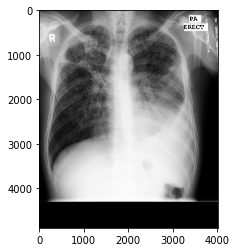

In [23]:
#Importing libraries.
import cv2
import numpy as np
from sklearn.decomposition import PCA

#Reading an image and printing the shape of the image. 
img = cv2.imread("/content/drive/My Drive/TB_classification_project/train/TB/VTYNBFTO.png")
print(img.shape)
plt.imshow(img)

In [24]:
img_r = np.reshape(img_r, (225, 582)) 

print(img_r.shape) 

NameError: ignored

In [ ]:
pca = PCA(32).fit(img_r) 
img_transformed = pca.transform(img_r) 
print(img_transformed.shape)
print(np.sum(pca.explained_variance_ratio_) )

#Retrieving the results of the image after Dimension reduction.
temp = pca.inverse_transform(img_transformed) 
print(temp.shape)
temp = np.reshape(temp, (225,225 ,3)) 
print(temp.shape) 
plt.imshow(temp)